# Install the libraries

In [2]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import AdaptiveEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    adapt = AdaptiveEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

# Inpainting

In [3]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Config

In [4]:
config["exp_params"]["batch_size"] = 1
dm = mnist_dataloader_test(config, path=path)

In [5]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

# Adaptive Experiments

In [6]:
config["operator_params"]["size"] = 28

In [14]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    avg_error = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.adaptive_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        plt.show()
    return avg_error

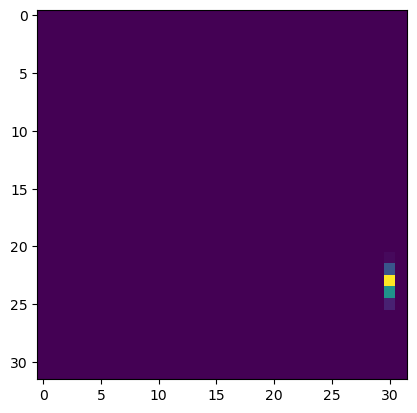

100%|██████████| 10/10 [00:00<00:00, 32.60it/s]


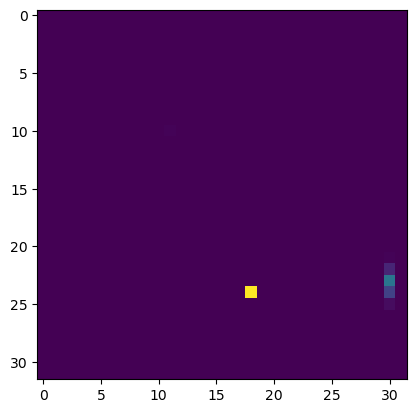

100%|██████████| 10/10 [00:00<00:00, 27.60it/s]


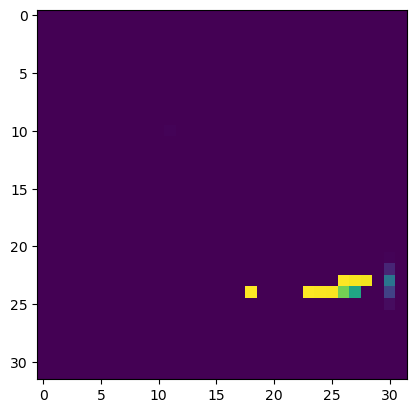

100%|██████████| 10/10 [00:00<00:00, 27.63it/s]


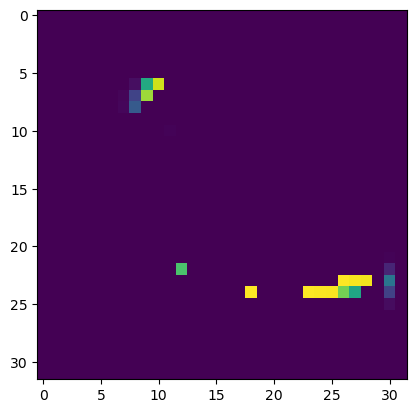

100%|██████████| 10/10 [00:00<00:00, 27.96it/s]


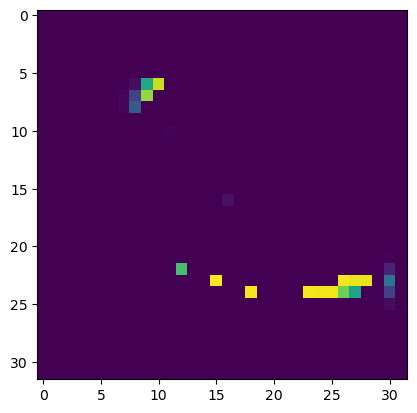

100%|██████████| 10/10 [00:00<00:00, 27.80it/s]


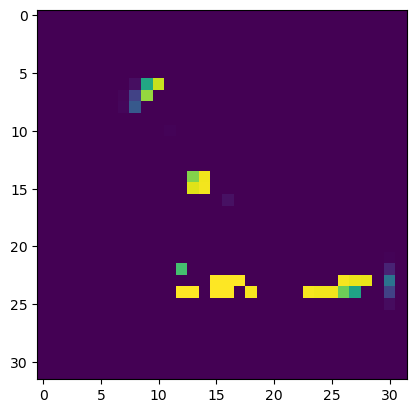

100%|██████████| 10/10 [00:00<00:00, 27.67it/s]


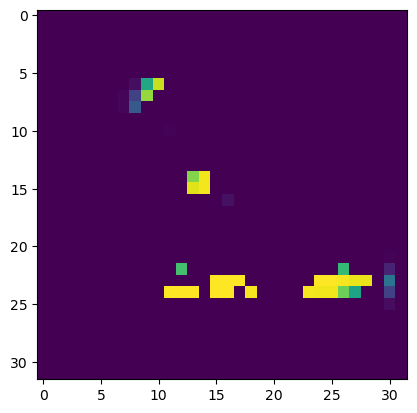

100%|██████████| 10/10 [00:00<00:00, 27.96it/s]


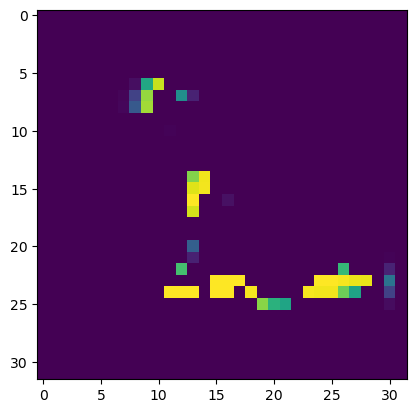

100%|██████████| 10/10 [00:00<00:00, 28.75it/s]


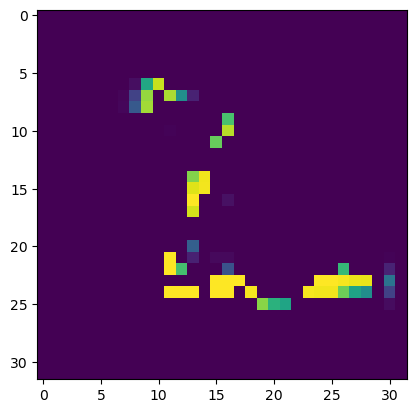

100%|██████████| 10/10 [00:00<00:00, 29.37it/s]


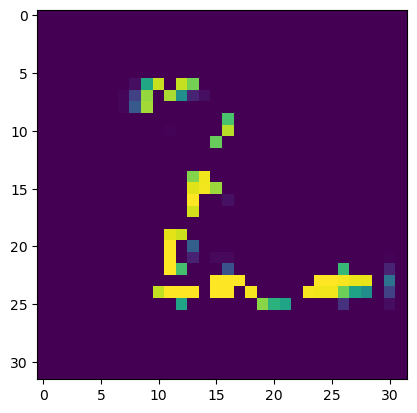

100%|██████████| 10/10 [00:00<00:00, 29.29it/s]


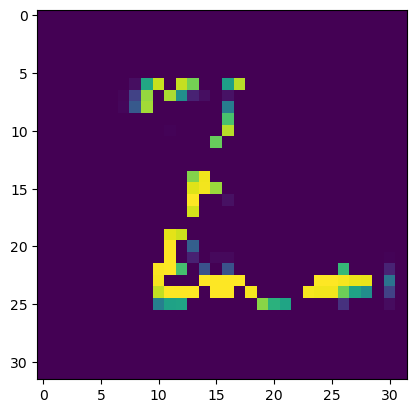

100%|██████████| 10/10 [00:00<00:00, 29.73it/s]


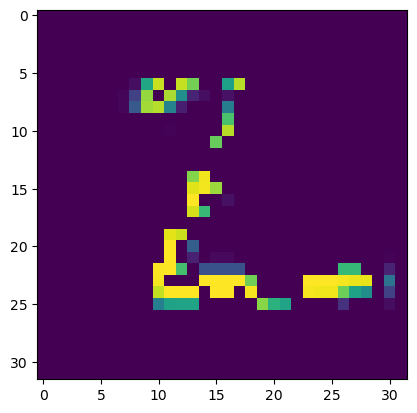

100%|██████████| 10/10 [00:00<00:00, 29.20it/s]


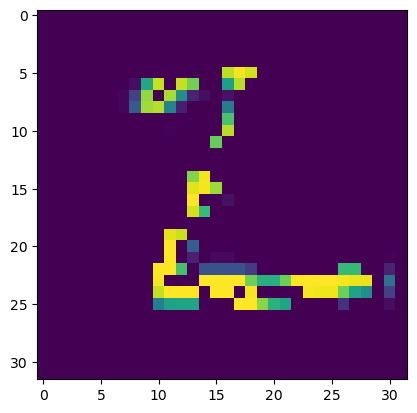

100%|██████████| 10/10 [00:00<00:00, 29.88it/s]


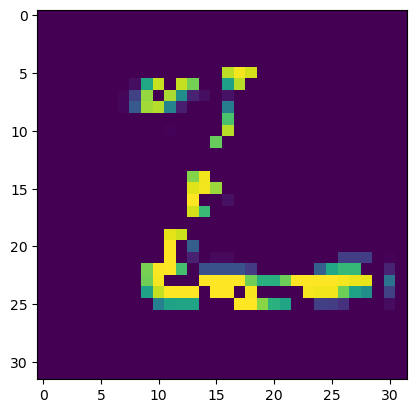

100%|██████████| 10/10 [00:00<00:00, 29.49it/s]


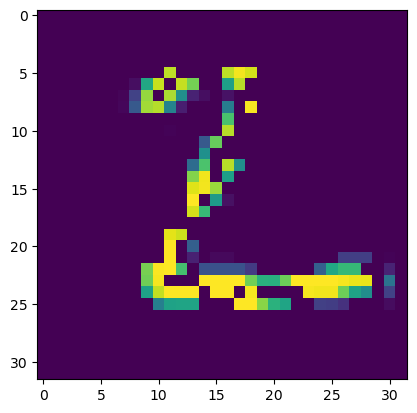

100%|██████████| 10/10 [00:00<00:00, 29.53it/s]


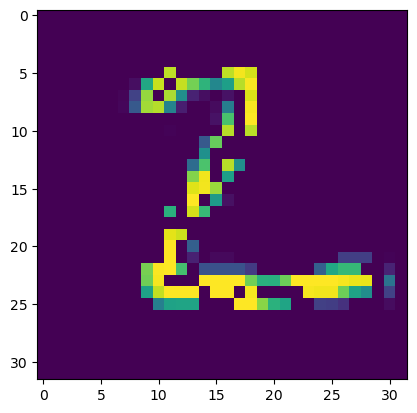

100%|██████████| 10/10 [00:00<00:00, 29.35it/s]


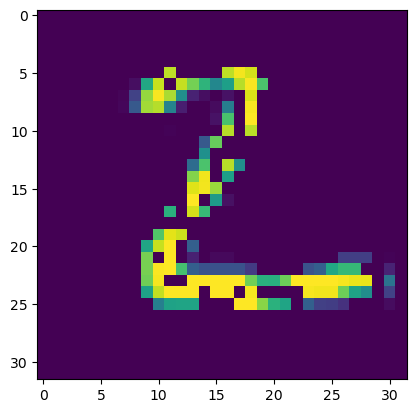

100%|██████████| 10/10 [00:00<00:00, 28.94it/s]


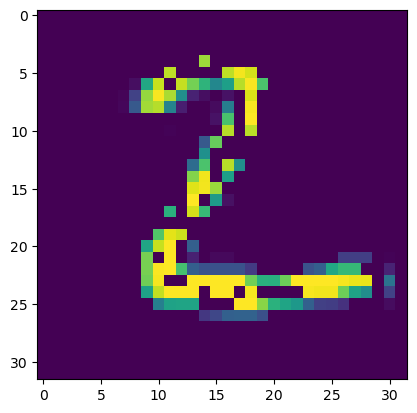

100%|██████████| 10/10 [00:00<00:00, 29.22it/s]


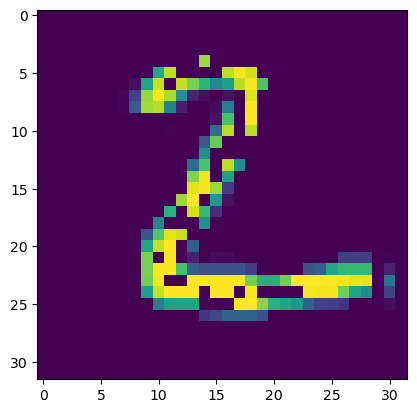

100%|██████████| 10/10 [00:00<00:00, 29.19it/s]


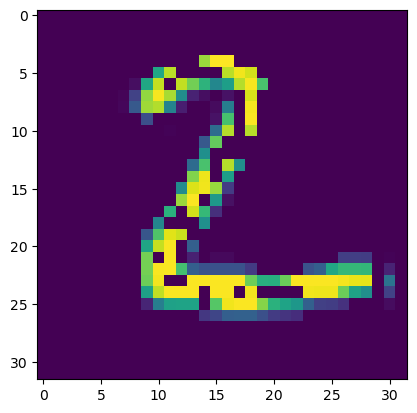

100%|██████████| 10/10 [00:00<00:00, 29.19it/s]


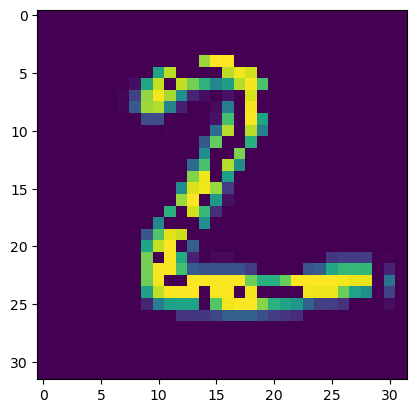

In [11]:
avg_error = adaptive_iteration(x)

In [16]:
def non_adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    avg_error = []
    for i in range(20):
        imgs = torch.zeros(100, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in trange(0, 100):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.non_adaptive_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        plt.show()
    return avg_error

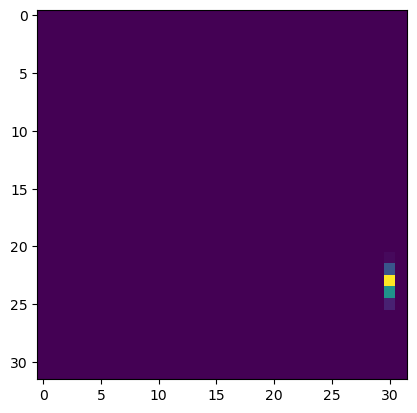

100%|██████████| 100/100 [00:03<00:00, 29.35it/s]


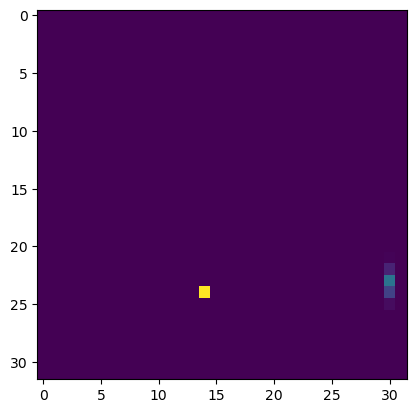

100%|██████████| 100/100 [00:03<00:00, 28.80it/s]


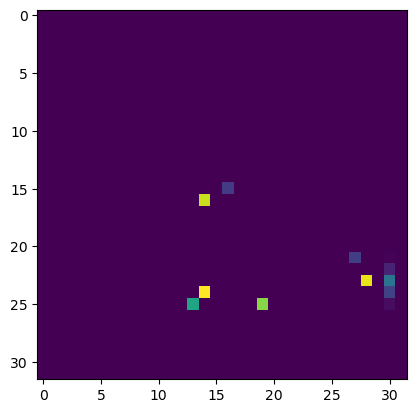

100%|██████████| 100/100 [00:03<00:00, 28.84it/s]


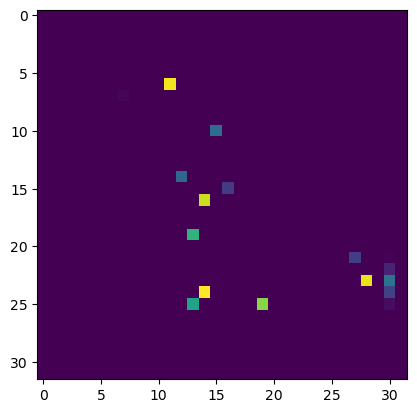

100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


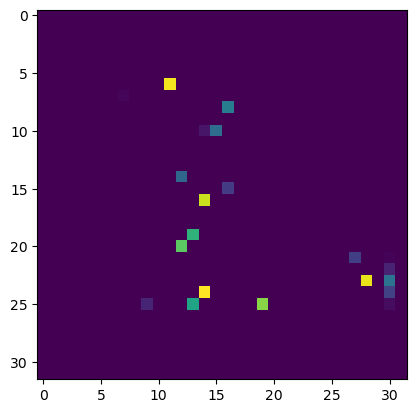

100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


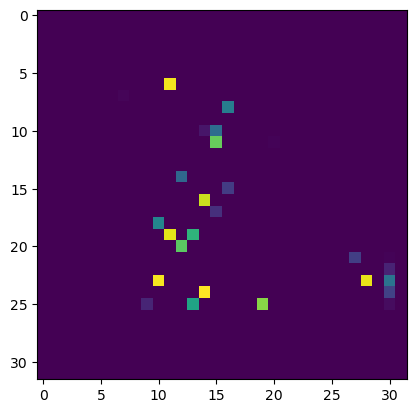

100%|██████████| 100/100 [00:03<00:00, 31.35it/s]


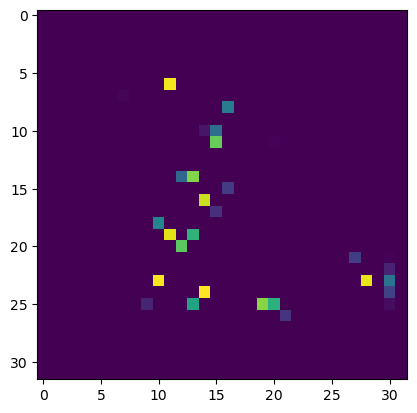

100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


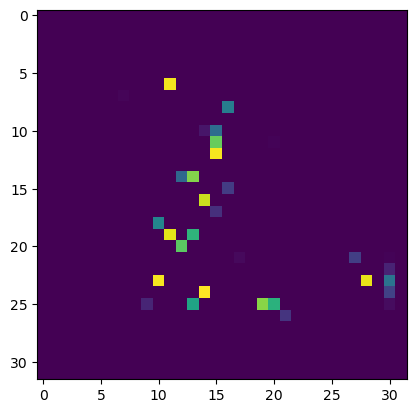

100%|██████████| 100/100 [00:03<00:00, 28.85it/s]


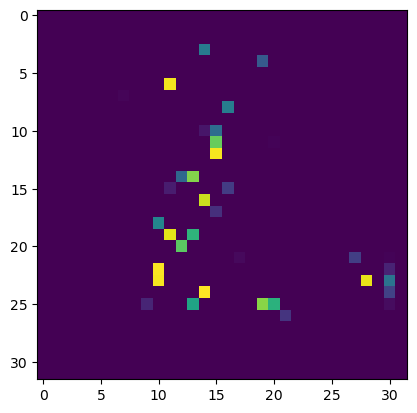

100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


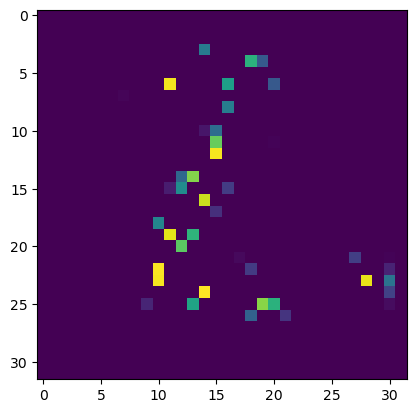

100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


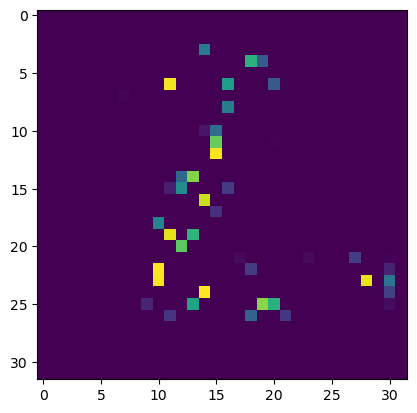

100%|██████████| 100/100 [00:03<00:00, 30.28it/s]


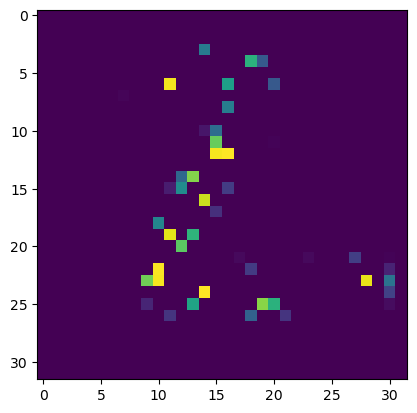

100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


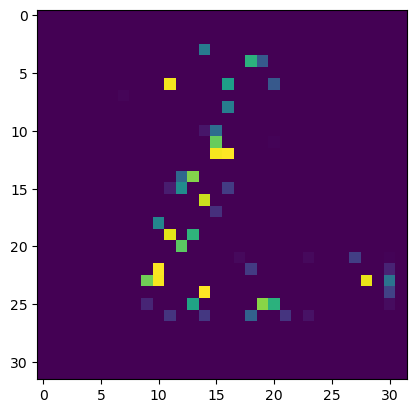

100%|██████████| 100/100 [00:03<00:00, 30.49it/s]


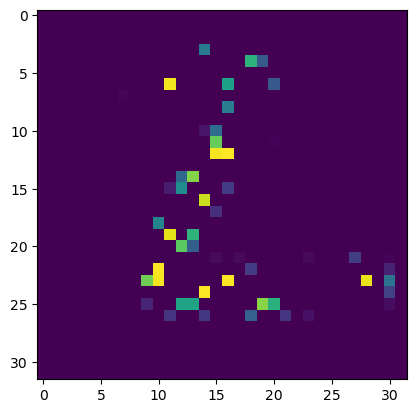

100%|██████████| 100/100 [00:03<00:00, 28.94it/s]


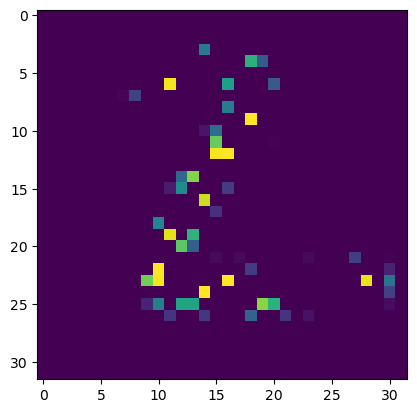

100%|██████████| 100/100 [00:03<00:00, 31.51it/s]


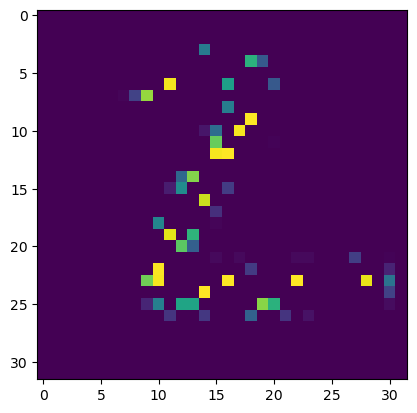

100%|██████████| 100/100 [00:03<00:00, 30.03it/s]


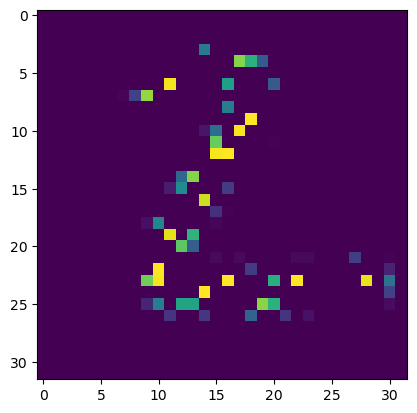

100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


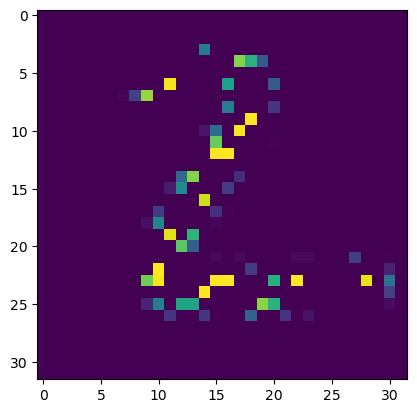

100%|██████████| 100/100 [00:03<00:00, 29.11it/s]


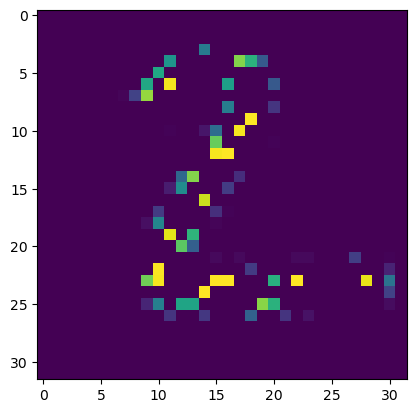

100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


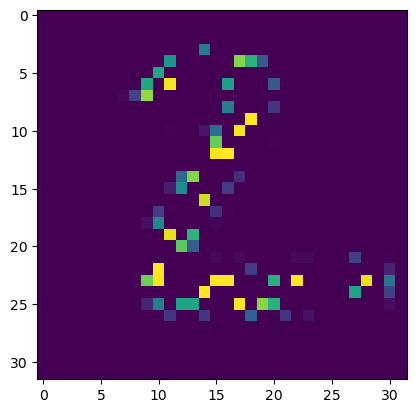

100%|██████████| 100/100 [00:03<00:00, 29.08it/s]


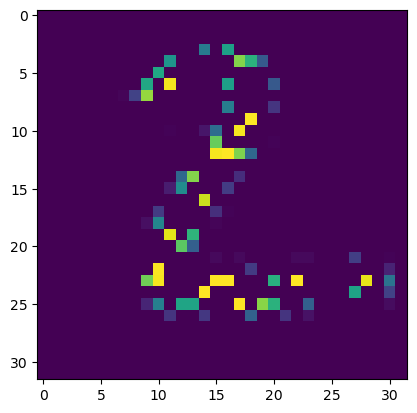

In [17]:
avg_error_non_adptive = non_adaptive_iteration(x)

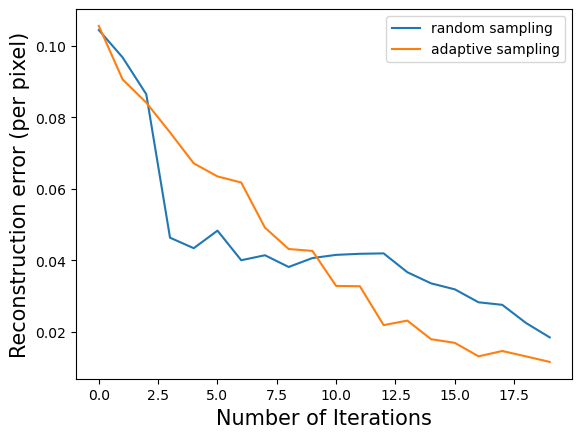

In [18]:
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.plot(avg_error_non_adptive)
plt.plot(avg_error)
plt.legend(['random sampling','adaptive sampling'])
plt.show()

In [31]:
def adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    avg_error = []
    n_samples = 10
    num_iter = 20
    for i in range(num_iter):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.adaptive_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
    return np.array(avg_error, dtype=np.float32)

In [32]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [33]:
avg_error = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = adaptive_iteration(x)
    avg_error = ((t-1)/t)*avg_error + (1/t)*error

100%|██████████| 99/99 [11:00<00:00,  6.67s/it]


In [7]:
def non_adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    error = []
    num_iter = 20
    for _ in range(num_iter):
        x_tilde = adapt.ebm.operator(x)
        x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
        error.append(reconstruction_error(x, x_hat).detach().cpu())
        A = adapt.non_adaptive_sample(torch.zeros(1, 32, 32))
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
    return np.array(error, dtype=np.float32)

In [26]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [27]:
avg_error_non_adaptive = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = non_adaptive_iteration(x)
    avg_error_non_adaptive = ((t-1)/t)*avg_error_non_adaptive + (1/t)*error

100%|██████████| 99/99 [01:09<00:00,  1.43it/s]


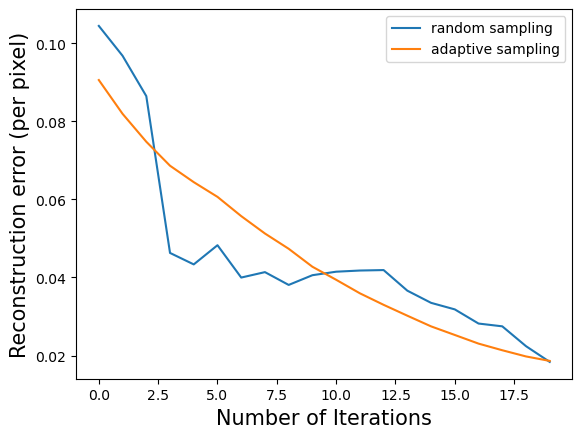

In [46]:
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.plot(avg_error_non_adptive)
plt.plot(avg_error)
plt.legend(['random sampling','adaptive sampling'])
plt.show()

In [20]:
def random_and_adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    error = []
    num_iter = 7
    for _ in range(num_iter):
        x_tilde = adapt.ebm.operator(x)
        x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
        error.append(reconstruction_error(x, x_hat).detach().cpu())
        A = adapt.non_adaptive_sample(torch.zeros(1, 32, 32))
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
    num_iter = 13
    n_samples = 10
    for _ in range(num_iter):
        x_tilde = adapt.ebm.operator(x)
        x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
        _error = []
        imgs = torch.zeros(n_samples, 32, 32)
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            _error.append(reconstruction_error(x, x_hat).detach().cpu())
        error.append(sum(_error)/len(_error))
        A = adapt.adaptive_sample(torch.zeros(1, 32, 32))
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
    return np.array(error, dtype=np.float32)

In [23]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [24]:
avg_error_random_adaptive = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = random_and_adaptive_iteration(x)
    avg_error_random_adaptive = ((t-1)/t)*avg_error_random_adaptive + (1/t)*error

100%|██████████| 99/99 [08:12<00:00,  4.97s/it]


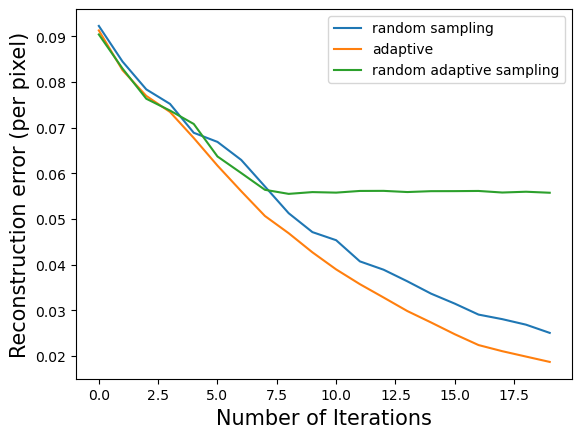

In [36]:
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.plot(avg_error_non_adaptive)
plt.plot(avg_error)
plt.plot(avg_error_random_adaptive)
plt.legend(['random sampling', 'adaptive', 'random adaptive sampling'])
plt.show()